In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import re
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
df1 = pd.read_csv("BankFAQs.csv")
df1.head()

,Question,Answer,Class
0,What are the documents required for opening a ...,Following documents are required to open a Cur...,accounts
1,Can I transfer my Current Account from one bra...,"Yes, Current Accounts can be transferred from ...",accounts
2,My present status is NRI. What extra documents...,NRI/PIO can open the proprietorship/partnershi...,accounts
3,What are the documents required for opening a ...,Following documents are required for opening a...,accounts
4,What documents are required to change the addr...,Following documents are required to change the...,accounts


In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1773 entries, 0 to 1772
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Question  1773 non-null   object
 1   Answer    1773 non-null   object
 2   Class     1773 non-null   object
dtypes: object(3)
memory usage: 41.7+ KB


In [4]:
df1.isna().sum()

Question    0
Answer      0
Class       0
dtype: int64

In [5]:
df1.head()

,Question,Answer,Class
0,What are the documents required for opening a ...,Following documents are required to open a Cur...,accounts
1,Can I transfer my Current Account from one bra...,"Yes, Current Accounts can be transferred from ...",accounts
2,My present status is NRI. What extra documents...,NRI/PIO can open the proprietorship/partnershi...,accounts
3,What are the documents required for opening a ...,Following documents are required for opening a...,accounts
4,What documents are required to change the addr...,Following documents are required to change the...,accounts


In [6]:
df2 = pd.read_csv("Bank_faq.csv")
df2.head()

,Question,Answer,Class
0,i need customer support,Sure. I'd be happy to. What's up?,accounts
1,I would like to transfer money,What's the destination country?,fundstransfer
2,how are you?,"""Doing great, thanks.""",accounts
3,what can you do for me?,"""I could transfer money for you, or I can bloc...",accounts
4,Hi,"""Hi there! What do you want me to do, today?""",accounts


In [7]:
df = pd.concat([df1, df2], axis =0)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1793 entries, 0 to 19
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Question  1793 non-null   object
 1   Answer    1793 non-null   object
 2   Class     1793 non-null   object
dtypes: object(3)
memory usage: 56.0+ KB


Exploratory Data Analysis

<Axes: xlabel='Class', ylabel='Count'>

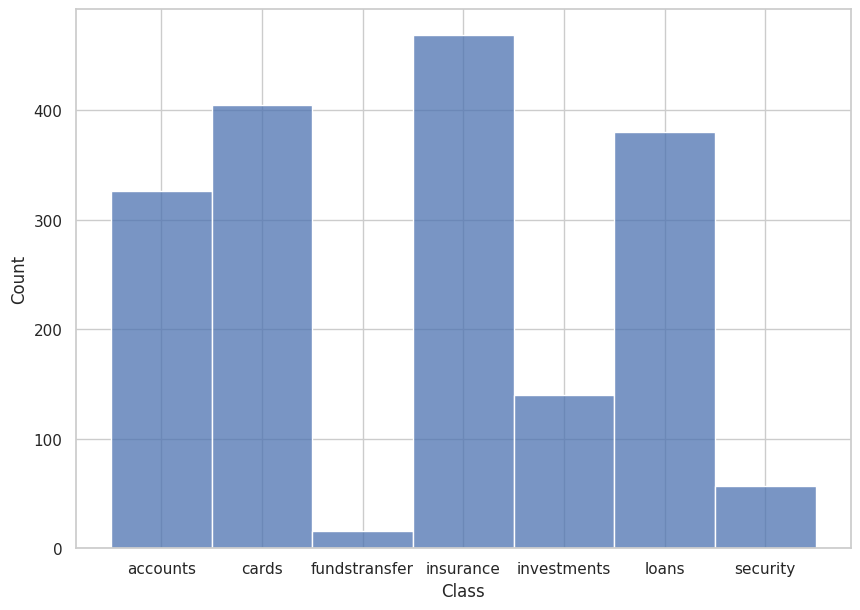

In [9]:
plt.figure(figsize=(10,7))
sb.set(font_scale=1)
sb.set_style('whitegrid')
sb.histplot(df['Class'])

•	Maximum Query arises in Insurance Class while least query comes under Fund Transfer Section.
•	Cards, Account and Loan Enquiries are also high enough.
•	Fewer Enquiries can be seen in Investments and Security.

<Axes: ylabel='Class'>

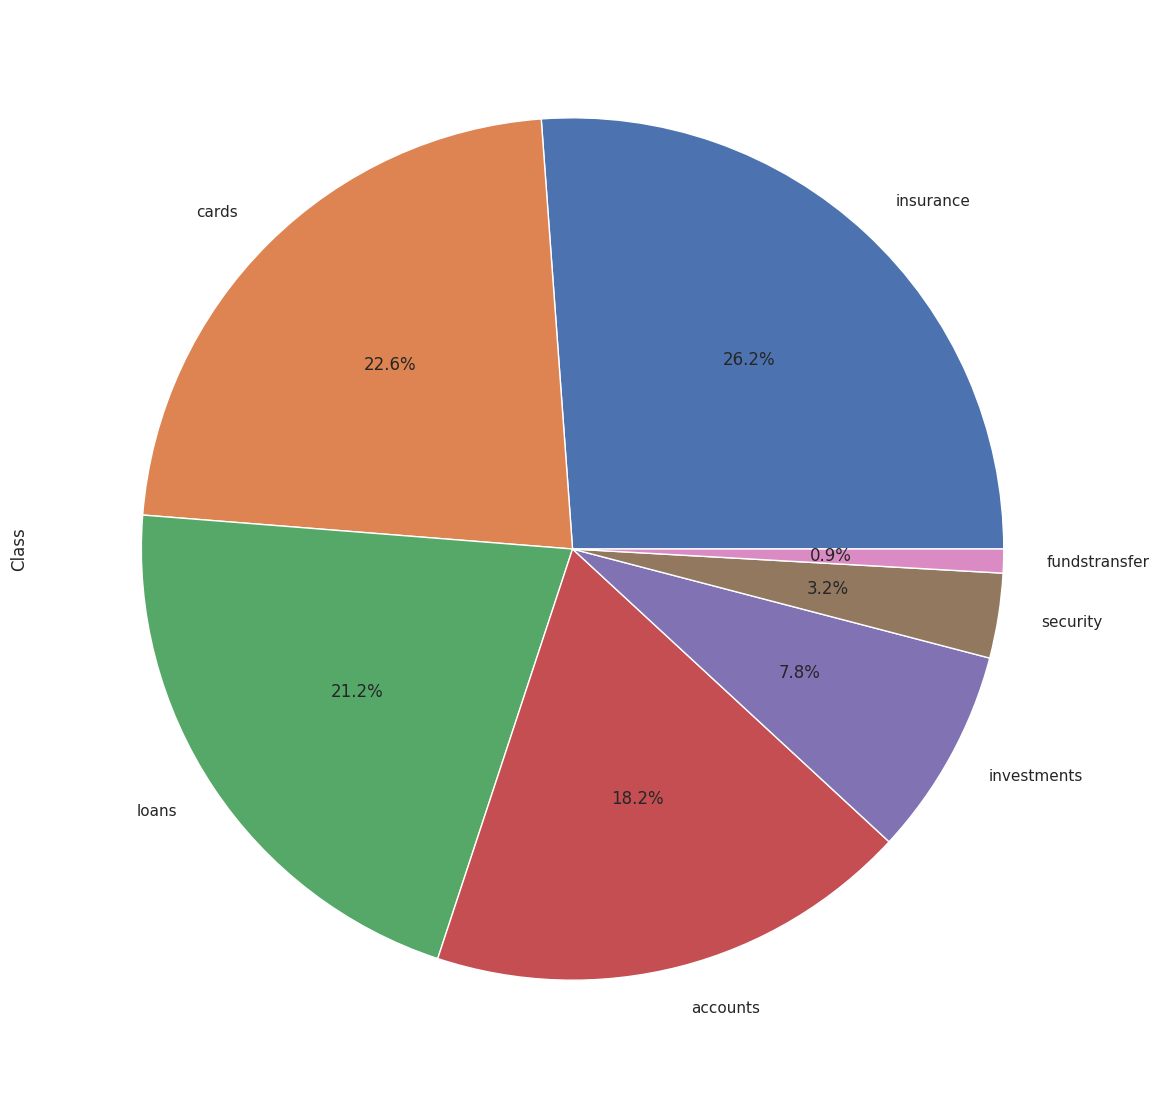

In [10]:
plt.figure(figsize=(20,14))
df['Class'].value_counts().plot(kind = 'pie', autopct='%1.1f%%')


In [11]:
26.2+22.6+21.2+18.2

88.2

•	For Insurance 26.2% enquiries, For Cards 22.6% enquiries, For Loans 21.2% enquiries and For Accounts 18.2% enquiries are       there.
•	Security and Fund Transfer are having combined enquiry of 4.1% only.
•	More than 88% enquiries are under 4 classes out of 7 classes.


In [12]:
df.head()

,Question,Answer,Class
0,What are the documents required for opening a ...,Following documents are required to open a Cur...,accounts
1,Can I transfer my Current Account from one bra...,"Yes, Current Accounts can be transferred from ...",accounts
2,My present status is NRI. What extra documents...,NRI/PIO can open the proprietorship/partnershi...,accounts
3,What are the documents required for opening a ...,Following documents are required for opening a...,accounts
4,What documents are required to change the addr...,Following documents are required to change the...,accounts


In [13]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [14]:
def remove_punc(txt):
    txt_wo_punct = "".join([i for i in txt if i not in string.punctuation])
    return txt_wo_punct

In [15]:
df['Question'] = df['Question'].apply(lambda x: remove_punc(x))
df['Answer'] = df['Answer'].apply(lambda x: remove_punc(x))
df.head()

,Question,Answer,Class
0,What are the documents required for opening a ...,Following documents are required to open a Cur...,accounts
1,Can I transfer my Current Account from one bra...,Yes Current Accounts can be transferred from o...,accounts
2,My present status is NRI What extra documents ...,NRIPIO can open the proprietorshippartnership ...,accounts
3,What are the documents required for opening a ...,Following documents are required for opening a...,accounts
4,What documents are required to change the addr...,Following documents are required to change the...,accounts


In [16]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [17]:
stop_words = set(stopwords.words('english'))

In [18]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [19]:
df['Question'][:5]

0    What are the documents required for opening a ...
1    Can I transfer my Current Account from one bra...
2    My present status is NRI What extra documents ...
3    What are the documents required for opening a ...
4    What documents are required to change the addr...
Name: Question, dtype: object

In [20]:
wnl = WordNetLemmatizer()

In [21]:
def clean(content):
    word_tok = nltk.word_tokenize(content)
    cleaned_words = [word for word in word_tok if word not in stop_words]
    cleaned_words = [wnl.lemmatize(word) for word in cleaned_words]
    return ' '.join(cleaned_words)

In [22]:
questions = df['Question'].values

In [23]:
import nltk
nltk.download('punkt')

X = []

for question in questions:
    X.append(clean(question))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [24]:
X[:15]

['What document required opening Current Account sole proprietorship firm',
 'Can I transfer Current Account one branch another',
 'My present status NRI What extra document required opening Sole Proprietorship Current Account',
 'What document required opening Current Account Limited Liability Partnership',
 'What document required change address entity',
 'What document required opening Current Account company',
 'Who partner partnership firm',
 'What time taken realize outstation cheque',
 'Can individual open Current Account',
 'Can EEFC Account opened Special Economic Zone SEZ Units',
 'What I case I unable access Companys Current Account',
 'What transaction included part free intercity clearing limit',
 'How MN Bank Premium CA different regular CA offered bank',
 'Must I open Premium Current account location I company office',
 'Can I access Premium Current Account MN Bank branch']

In [25]:
tf = TfidfVectorizer()
X = tf.fit_transform(X)

In [26]:
X.shape

(1793, 1265)

In [27]:
le = LabelEncoder()
le.fit(df['Class'])

LabelEncoder()

In [28]:
y = le.fit_transform(df['Class'])

In [29]:
y.shape

(1793,)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=500)


In [31]:
model_params= {
    'svm':{
        'model':SVC(gamma='auto'),
        'params':{
            'C': [1,10,20],
            'kernel': ['rbf', 'linear']
        }
    },
    'random_forest':{
        'model':RandomForestClassifier(),
        'params':{
            'n_estimators': [1,5,10]
        }
    },
    'logistic_regression':{
        'model':LogisticRegression(solver='liblinear', multi_class='auto'),
        'params':{
            'C': [1,5,10]
        }
    }
    
}

In [32]:
scores = []

for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv = 5, return_train_score=False)
    clf.fit(X, y)
    scores.append({
        'model': model_name,
        'best_score':clf.best_score_,
        'best_params' :clf.best_params_
    })

In [33]:
df_best_score = pd.DataFrame(scores, columns=['model','best_score','best_params' ])
df_best_score

,model,best_score,best_params
0,svm,0.871152,"{'C': 1, 'kernel': 'linear'}"
1,random_forest,0.836560,{'n_estimators': 10}
2,logistic_regression,0.883975,{'C': 10}


In [34]:
final_model = SVC(kernel='linear', C=1.0, gamma='auto'  )
final_model.fit(X_train, y_train)

SVC(gamma='auto', kernel='linear')

In [35]:
final_model.score(X_test, y_test)

0.9153674832962138

In [36]:
class_=le.inverse_transform(final_model.predict(X))

In [37]:
class_

array(['accounts', 'accounts', 'accounts', ..., 'loans', 'loans',
       'accounts'], dtype=object)

In [38]:
import numpy as np

In [39]:
final_model.predict(X_test)

array([1, 3, 3, 1, 5, 0, 5, 3, 0, 1, 3, 0, 1, 3, 3, 3, 1, 0, 3, 0, 1, 3,
       6, 5, 0, 3, 0, 5, 3, 5, 3, 1, 3, 5, 3, 0, 0, 3, 5, 1, 5, 0, 3, 4,
       3, 3, 4, 4, 3, 1, 0, 1, 5, 3, 1, 3, 3, 1, 3, 5, 3, 0, 3, 1, 1, 0,
       0, 3, 1, 1, 1, 5, 1, 0, 1, 3, 3, 3, 5, 3, 3, 3, 5, 5, 5, 1, 1, 3,
       3, 0, 0, 3, 4, 1, 1, 5, 1, 5, 3, 5, 5, 0, 5, 3, 0, 0, 3, 3, 2, 3,
       0, 0, 1, 0, 0, 6, 5, 3, 1, 0, 4, 1, 3, 3, 3, 3, 5, 3, 0, 0, 1, 0,
       3, 1, 5, 4, 0, 0, 1, 4, 4, 1, 3, 3, 3, 1, 3, 1, 5, 3, 5, 0, 3, 0,
       3, 0, 0, 0, 1, 0, 3, 0, 3, 5, 5, 1, 1, 0, 3, 4, 1, 0, 3, 3, 0, 0,
       1, 3, 3, 5, 3, 5, 1, 0, 0, 5, 0, 3, 5, 5, 3, 3, 3, 3, 6, 3, 3, 0,
       1, 3, 3, 0, 3, 6, 3, 5, 6, 1, 1, 6, 3, 3, 1, 0, 0, 5, 1, 0, 1, 1,
       3, 0, 5, 3, 4, 5, 5, 5, 4, 1, 0, 5, 0, 5, 3, 5, 5, 1, 5, 3, 0, 1,
       3, 3, 4, 0, 0, 5, 3, 5, 3, 1, 0, 3, 1, 5, 0, 0, 4, 5, 1, 3, 5, 3,
       5, 3, 3, 3, 0, 1, 1, 4, 3, 1, 3, 5, 5, 5, 1, 3, 1, 4, 0, 6, 1, 0,
       3, 5, 0, 5, 3, 3, 5, 1, 6, 0, 1, 5, 1, 4, 5,

In [40]:
from sklearn.metrics.pairwise import cosine_similarity
user_question = "How to open savings account"
## Create a TF-IDF vectorizer to convert the text data and query to a vector representation


# Get the vector representationthe question and answer
answer_vectors = tf.transform(df['Answer']).toarray()
test_vector = tf.transform([user_question]).toarray()
# Calculate the cosine similarity between both vectors
cosine_sims = cosine_similarity(answer_vectors, test_vector)
# Get the index of the most similar text to the query
most_similar_idx = np.argmax(cosine_sims)
# Print the most similar text as the answer to the query
print(df.iloc[most_similar_idx]['Answer'])

An Institutional Savings Account is a ZERO BALANCE account


In [41]:

def get_response(usrText):

    while True:

        if usrText.lower() == "bye":
            return "Bye"

        GREETING_INPUTS = ["hello", "hi", "greetings", "sup", "what's up", "hey","hiii","hii","yo"]

        a = [x.lower() for x in GREETING_INPUTS]

        sd=["Thanks","Welcome"]

        d = [x.lower() for x in sd]


        am=["OK"]

        c = [x.lower() for x in am]

        t_usr = tf.transform([clean(usrText.strip().lower())])
        class_ = le.inverse_transform(final_model.predict(t_usr))

        questionset = df[df['Class'].values == class_]

        cos_sims = []
        for question in questionset['Question']:
            sims = cosine_similarity(tf.transform([question]), t_usr)

            cos_sims.append(sims)

        ind = cos_sims.index(max(cos_sims))

        b = [questionset.index[ind]]

        if usrText.lower() in a:

            return ("Hi, I'm Emily!\U0001F60A")


        if usrText.lower() in c:
            return "Ok...Alright!\U0001F64C"

        if usrText.lower() in d:
            return ("My pleasure! \U0001F607")

        if max(cos_sims) > [[0.]]:
            a = df['Answer'][questionset.index[ind]]+"   "
            return a


        elif max(cos_sims)==[[0.]]:
           return "sorry! \U0001F605"

In [44]:
import streamlit as st
import os

In [46]:
st.title("V&S Banking Virtual Assistant")

st.write("Hi,How can I help you?")

user_input = st.text_input("You: ")

if user_input:
    response = get_response(user_input)

    st.write(response)